# BP算法从0实现
- 参考资料：[徒手实现反向传播算法](https://www.bilibili.com/video/BV12b421v7qq/?spm_id_from=333.337.search-card.all.click&vd_source=2d923fa915f60fa42bc78d9b6d067f68)

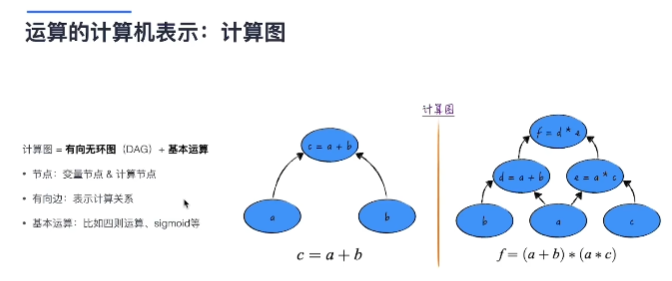

## 画图模块

In [43]:
# 定义计算图
class ScalarTmp:
  def __init__(self, value, prevs=[], op=None, label=''):
    # 节点值
    self.value = value
    # 直接的前序节点
    self.prevs = prevs
    # 运算符号
    self.op = op
    self.label = label
    self.grad = 0.0
    self.grad_wrt = {}
  
  def __repr__(self):
    return f'{self.value} | {self.op} | {self.label}'
  
  def __add__(self, other):
    # self + other触发
    value = self.value + other.value
    prevs = [self, other]
    output = ScalarTmp(value, prevs, op="+")
    output.grad_wrt[self] = 1
    output.grad_wrt[other] = 1
    return output
  
  def __mul__(self, other):
    # self * other触发
    value = self.value * other.value
    prevs = [self, other]
    output = ScalarTmp(value, prevs, op="*")
    output.grad_wrt[self] = other.value
    output.grad_wrt[other] = self.value
    return output


In [44]:
a = ScalarTmp(1.0,label="a")
b = ScalarTmp(2.0,label="b")
c = a + b
c

3.0 | + | 

In [45]:
from graphviz import Digraph

# 画图函数
def _trace(root):
  # 遍历计算图中的所有点和边
  nodes, edges = set(), set()
  def _build(v):
    if v not in nodes:
      nodes.add(v)
      for prev in v.prevs:
        edges.add((prev, v))
        _build(prev)
  _build(root)
  return nodes, edges

def draw_graph(root, direction='forward'):
  nodes , edges = _trace(root)
  rankdir = 'BT' if direction == 'forward' else 'TB'
  graph = Digraph(format='svg', graph_attr={'rankdir': rankdir})
  # 画点
  for node in nodes:
    label = node.label if node.op is None else node.op
    node_attr = f'{{ grad={node.grad} | value={node.value:.2f} | {label}}}'
    uid = str(id(node))
    graph.node(name=uid, label=node_attr, shape='record')
  
  # 画边
  for edge in edges:
    id1 = str(id(edge[0]))
    id2 = str(id(edge[1]))
    graph.edge(id1,id2)
  return graph

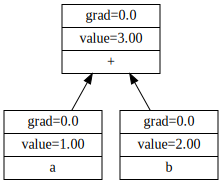

In [46]:
draw_graph(c)

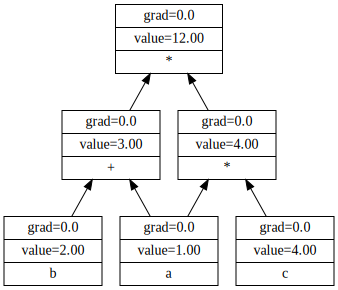

In [47]:
a = ScalarTmp(1.0,label="a")
b = ScalarTmp(2.0,label="b")
c = ScalarTmp(4.0,label="c")
d = a + b
e = a * c
f = d * e
draw_graph(f)

## BP算法

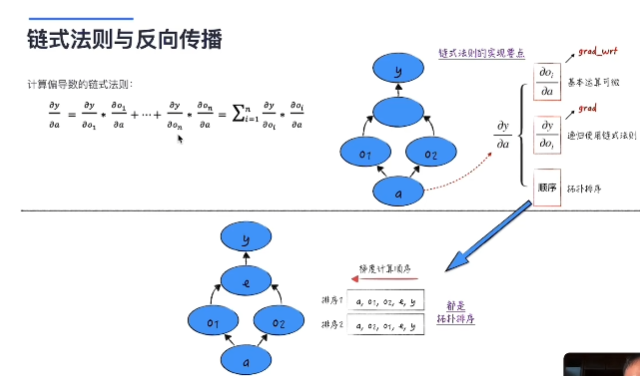

In [48]:
# 拓扑排序
def _top_order(root):
  # 利用深度优先搜素
  ordered, visited = [], set()
  def _add_prevs(node):
    if node not in visited:
      visited.add(node)
      for prev in node.prevs:
        _add_prevs(prev)
      ordered.append(node)
  _add_prevs(root)
  return ordered

In [49]:
_top_order(f)

[1.0 | None | a,
 2.0 | None | b,
 3.0 | + | ,
 4.0 | None | c,
 4.0 | * | ,
 12.0 | * | ]

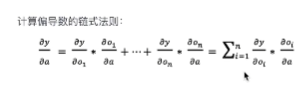

In [50]:
# BP算法
def backward(root):
  # 定义顶点的梯度为1
  root.grad = 1.0
  ordered = _top_order(root)
  for node in reversed(ordered):
    for v in node.prevs:
      v.grad += node.grad * node.grad_wrt[v]
  return root

In [51]:
backward(f)

12.0 | * | 

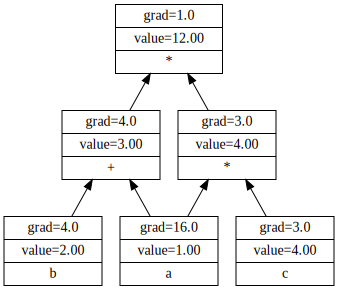

In [52]:
draw_graph(f)